In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch as t
import torchmetrics
from DiagnosisAI.utils.metrics import calculate_type_errors, calc_metrics
from DiagnosisAI.models.resnet3d import generate_model
from medmnist import INFO
import medmnist
import torch.nn as nn
import pandas as pd
from tqdm import tqdm
import numpy as np
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
from torch.utils import data
import matplotlib
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA


/home/michalheit/miniconda3/envs/mgr_dp/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Resnet18

In [3]:
logs = pd.read_csv('/mnt/e/mgr/trainings/logs/classif_3d_new/resnet18/logs.csv')
logs = logs[0:100]

In [4]:
logs.columns
metric_cols = ["accuracy", 'recall', 'precision', 'f1_score', 'val_recall', 'val_precision', 'val_accuracy', 'val_f1_score']
logs[metric_cols] = logs[metric_cols] * 100

In [5]:
log_train_loss = logs['train_loss']
log_val_loss = logs['val_loss']
epochs = np.arange(1, len(log_val_loss) + 1)

In [6]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}

matplotlib.rc('font', **font)

Text(0, 0.5, 'Wartość entropii krzyżowej')

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


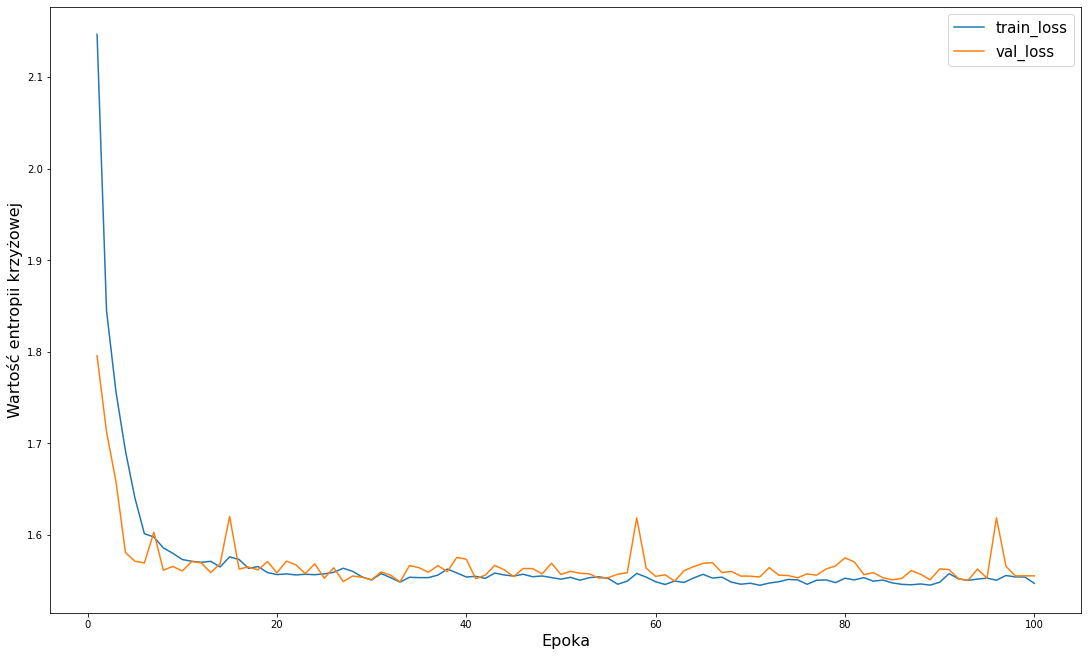

In [7]:
fig, ax = plt.subplots(figsize=(15, 9), constrained_layout=True)

ax.plot(epochs, log_train_loss)
ax.plot(epochs, log_val_loss)
ax.legend(["train_loss", "val_loss"], loc=0, prop={'size': 15})
ax.set_xlabel('Epoka', size=16)
ax.set_ylabel('Wartość entropii krzyżowej', size=16)

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


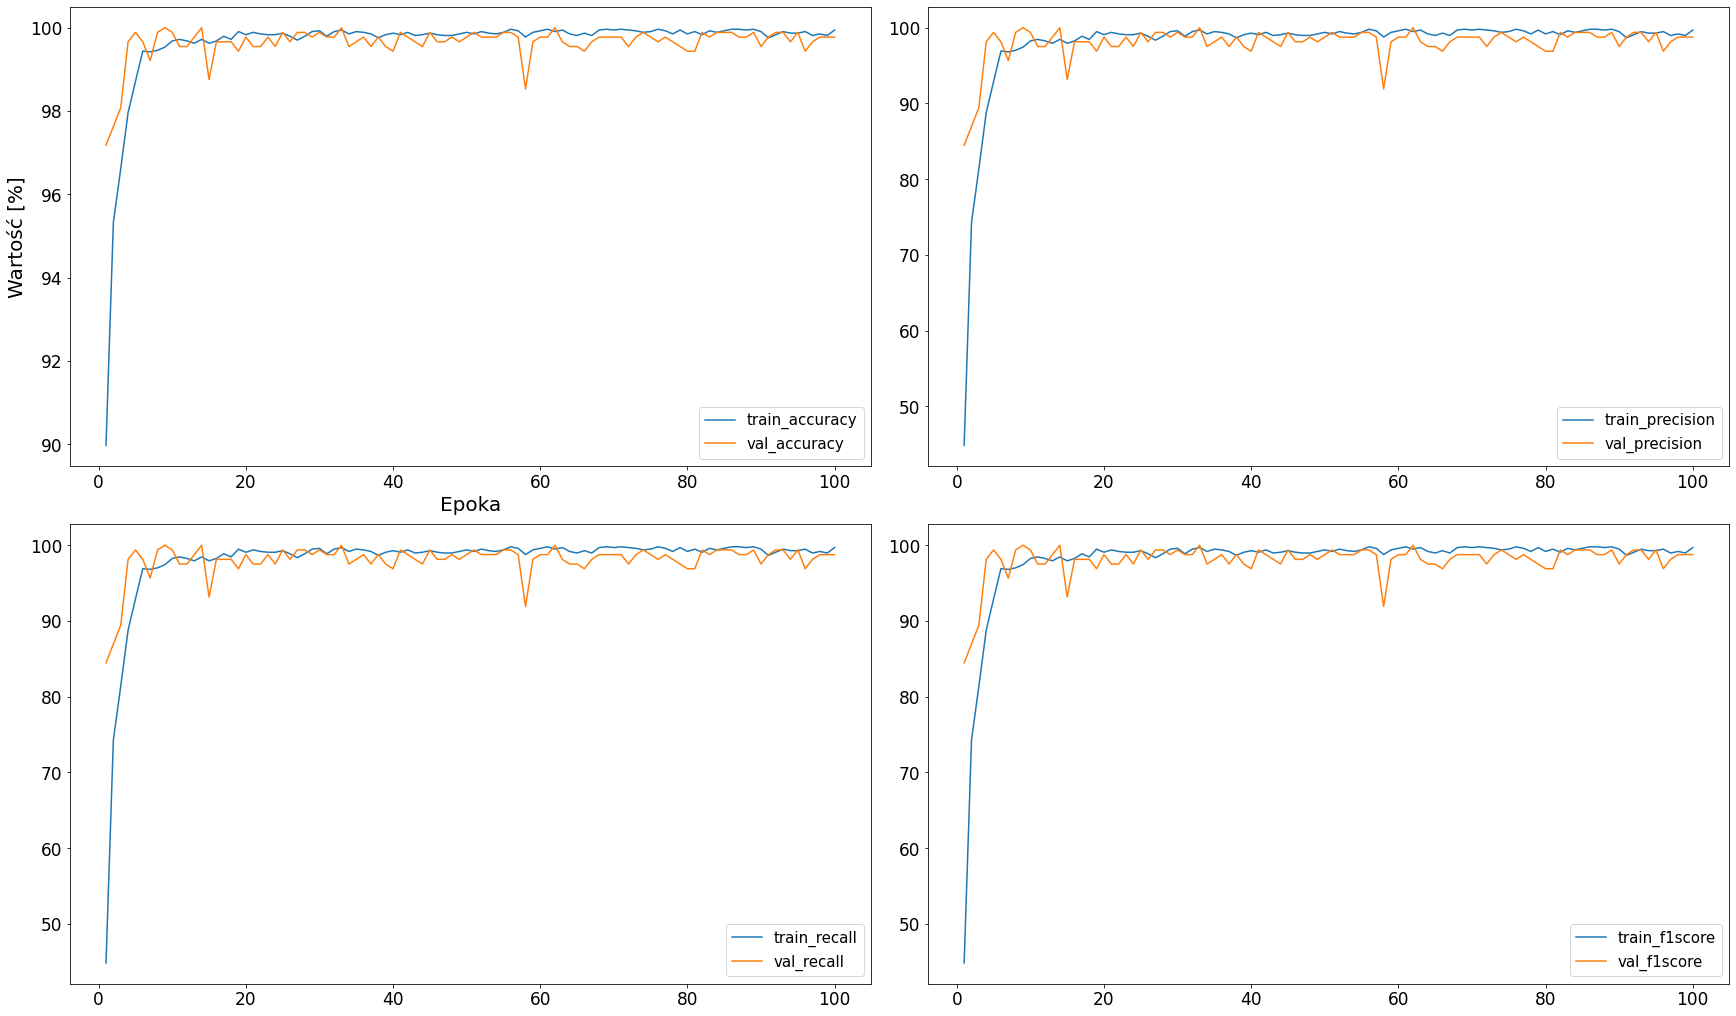

In [8]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 17}

matplotlib.rc('font', **font)

fig = plt.figure(figsize=(24, 14), constrained_layout=True)
spec = fig.add_gridspec(2, 2)
ax00 = fig.add_subplot(spec[0, 0])
ax01 = fig.add_subplot(spec[0, 1])
ax10 = fig.add_subplot(spec[1, 0], sharex=ax00)
ax11 = fig.add_subplot(spec[1, 1], sharex=ax01)
ax00.plot(epochs, logs['accuracy'])
ax00.plot(epochs, logs['val_accuracy'])
ax00.set_xlabel('Epoka', size=20)
ax00.set_ylabel('Wartość [%]', size=20)
ax00.legend(['train_accuracy', 'val_accuracy'], loc=0, prop={'size': 15})
ax01.plot(epochs, logs['precision'])
ax01.plot(epochs, logs['val_precision'])
ax01.legend(['train_precision', 'val_precision'], loc=0, prop={'size': 15})
ax10.plot(epochs, logs['recall'])
ax10.plot(epochs, logs['val_recall'])
ax10.legend(['train_recall', 'val_recall'], loc=0, prop={'size': 15})
ax11.plot(epochs, logs['f1_score'])
ax11.plot(epochs, logs['val_f1_score'])
ax11.legend(['train_f1score', 'val_f1score'], loc=0, prop={'size': 15})

In [9]:
batch_size = 8
data_flag = 'organmnist3d'
download = True
device = t.device('cpu')
info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])
test_dataset = DataClass(split='test',  download=download)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

Using downloaded and verified file: /home/michalheit/.medmnist/organmnist3d.npz


In [10]:
network = generate_model(model_depth=18, n_classes=11, n_input_channels=1)
network.fc

Linear(in_features=512, out_features=11, bias=True)

In [11]:
model_state_path = "../trainings/model_states/classif_3d/resnet18/model_state"
network.load_state_dict(t.load(model_state_path, map_location=device))

<All keys matched successfully>

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [17]:
network.eval()
global_tp = 0
global_fp = 0
global_tn = 0
global_fn = 0
accs = 0.0
recalls = 0.0
f1scores = 0.0
precisions = 0.0
cmatrix_all = 0
for i, (inputs, labels) in enumerate(tqdm(test_loader), 0):
    with t.no_grad():        
        outputs = network(inputs.type(t.float32))
    outputs = nn.Softmax(dim=1)(outputs)
    labels = nn.functional.one_hot(labels, num_classes=11)
    labels = labels.squeeze()

    pred_classes = t.argmax(outputs, dim=1)
    target_classes = t.argmax(labels, dim=1)

    cmatrix = confusion_matrix(target_classes, pred_classes, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
    cmatrix_all += cmatrix
    tp, fp, tn, fn = calculate_type_errors(pred_classes, target_classes, mode='classif_multiclass', num_classes=11)
    global_tp += tp.numpy()
    global_fp += fp.numpy()
    global_tn += tn.numpy()
    global_fn += fn.numpy()

    # accs += Accuracy()(pred_classes, target_classes).item()
    # recalls += Recall()(pred_classes, target_classes).item()
    # precisions += Precision()(pred_classes, target_classes).item()
    # f1scores += F1Score()(pred_classes, target_classes).item()

# calc metrics
recall, precision, acc, f1_score = calc_metrics(global_tp, global_fp, global_tn, global_fn)

print(f"Recall: {recall}, Precision: {precision}, Acc: {acc}, F1_score: {f1_score}")
# print(f"Metrics acc: {accs / (i+1)}, Recalls: {recalls / (i+1)}, Prec: {precisions / (i+1)}, f1: {f1scores / (i+1)}")

100%|██████████| 77/77 [00:13<00:00,  5.66it/s]

Recall: [[1.        ]
 [0.80882353]
 [0.75362319]
 [0.78461538]
 [0.83076923]
 [0.90909091]
 [0.89285714]
 [1.        ]
 [1.        ]
 [0.92753623]
 [0.88405797]], Precision: [[1.        ]
 [0.76388889]
 [0.75362319]
 [0.80952381]
 [0.81818182]
 [0.92307692]
 [1.        ]
 [0.95454545]
 [1.        ]
 [0.90140845]
 [0.91044776]], Acc: [[1.        ]
 [0.95081967]
 [0.9442623 ]
 [0.95737705]
 [0.96229508]
 [0.98196721]
 [0.99508197]
 [0.99836066]
 [1.        ]
 [0.98032787]
 [0.97704918]], F1_score: [[1.        ]
 [0.78571429]
 [0.75362319]
 [0.796875  ]
 [0.82442748]
 [0.91603053]
 [0.94339623]
 [0.97674419]
 [1.        ]
 [0.91428571]
 [0.89705882]]


<AxesSubplot:>

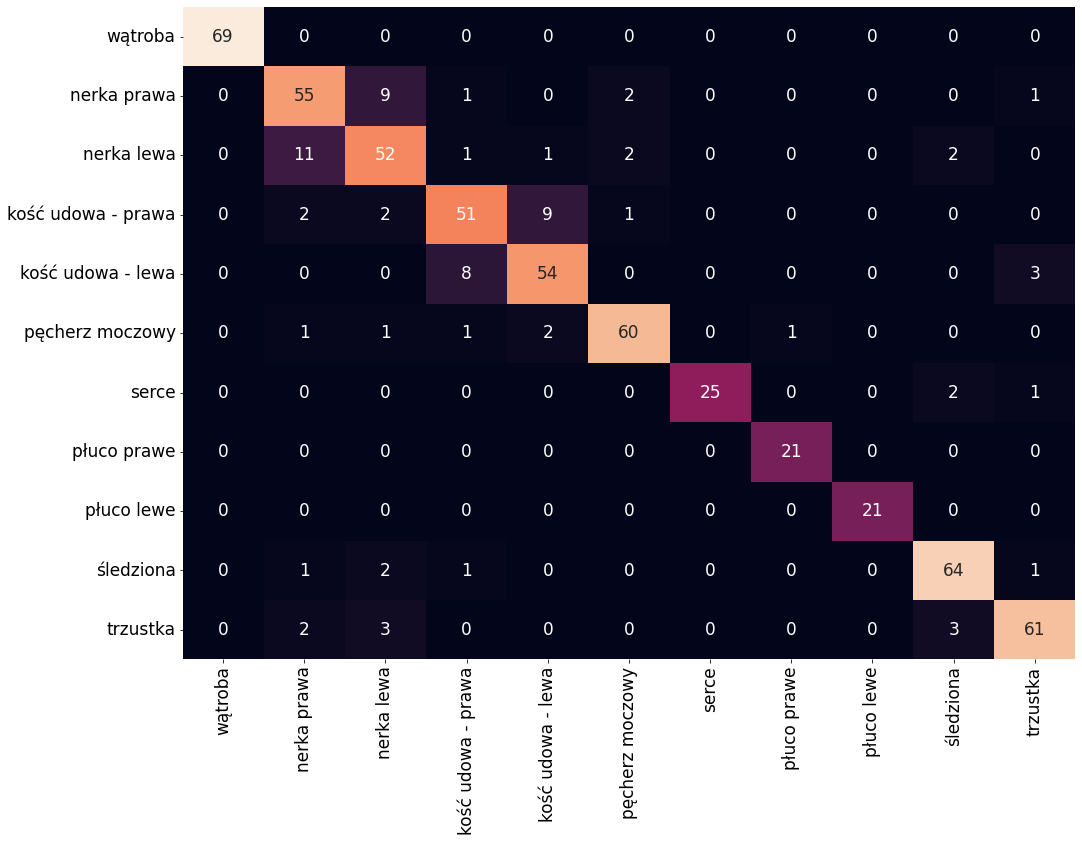

In [35]:
fig, ax  = plt.subplots(figsize=(16, 12))
labels = ['wątroba', "nerka prawa",'nerka lewa','kość udowa - prawa','kość udowa - lewa', 'pęcherz moczowy', 'serce','płuco prawe','płuco lewe','śledziona', 'trzustka']
df_cm = pd.DataFrame(cmatrix_all, index=labels, columns=labels)
sns.heatmap(df_cm, annot=True, cbar=False)

In [14]:
global_tp.sum(), global_fp.sum(), global_fn.sum(), global_tn.sum()

(533, 77, 77, 6023)

In [52]:
results = pd.DataFrame({'Recall': recall.flatten(), "Accuracy": acc.flatten(), "F1_score": f1_score.flatten(), "Precision": precision.flatten()})

In [53]:
results = results * 100
results.index = np.arange(1, 12)

In [55]:
results.round(2)

,Recall,Accuracy,F1_score,Precision
1,100.00,100.00,100.00,100.00
2,80.88,95.08,78.57,76.39
3,75.36,94.43,75.36,75.36
4,78.46,95.74,79.69,80.95
5,83.08,96.23,82.44,81.82
6,90.91,98.20,91.60,92.31
7,89.29,99.51,94.34,100.00
8,100.00,99.84,97.67,95.45
9,100.00,100.00,100.00,100.00
10,92.75,98.03,91.43,90.14


## Embeddings

In [56]:
embedd_network = nn.Sequential(*list(network.children())[:-1])

In [72]:
embedd_network.eval()
labels_e = []
embeddings = []
for i, (inputs, labels) in enumerate(tqdm(test_loader), 0):
    with t.no_grad():
        outputs = embedd_network(inputs.type(t.float32))
        embeddings.append(outputs.squeeze().numpy())
        labels_e.append(labels.squeeze().item())

100%|██████████| 610/610 [00:32<00:00, 18.71it/s]


In [89]:
labels_keys = np.arange(0, 11)
labels_map = np.arange(1, 12)
map_labels = {}
for idx, i in enumerate(labels_keys):
    map_labels[i] = labels_map[idx]
map_labels

{0: 1, 1: 2, 2: 3, 3: 4, 4: 5, 5: 6, 6: 7, 7: 8, 8: 9, 9: 10, 10: 11}

In [93]:
embeddings = np.array(embeddings)
labels_e = np.array(labels_e)
labels_e = np.vectorize(map_labels.get)(labels_e)

In [94]:
neighbors = NearestNeighbors(n_neighbors=10, algorithm='brute', metric='euclidean').fit(embeddings)

sprawdzanie najblizszych 5 sasiadow dla pierwszego wektora cech czyli labelu 10 (trzustki)

In [95]:
distances, indices = neighbors.kneighbors([embeddings[0]])

In [96]:
distances, indices

(array([[0.       , 3.1431758, 4.7513237, 5.176118 , 5.3200026, 5.910138 ,
         5.9485803, 5.967262 , 6.3393955, 6.3917785]], dtype=float32),
 array([[  0, 116, 114, 506, 596, 100, 351, 142, 250,  71]]))

Pierwszych 5 sasiadow ma label:

In [97]:
np.take(labels_e, indices.flatten())

array([11, 11, 11, 11, 11, 11, 11, 11, 11, 11])

Jak widać zgadza się

In [98]:
tsne_results = TSNE(n_components=2,verbose=1,metric='euclidean').fit_transform(embeddings)

/home/michalheit/miniconda3/envs/mgr_dp/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/michalheit/miniconda3/envs/mgr_dp/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 610 samples in 0.001s...
[t-SNE] Computed neighbors for 610 samples in 0.026s...
[t-SNE] Computed conditional probabilities for sample 610 / 610
[t-SNE] Mean sigma: 4.536653
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.230644
[t-SNE] KL divergence after 1000 iterations: 0.337363


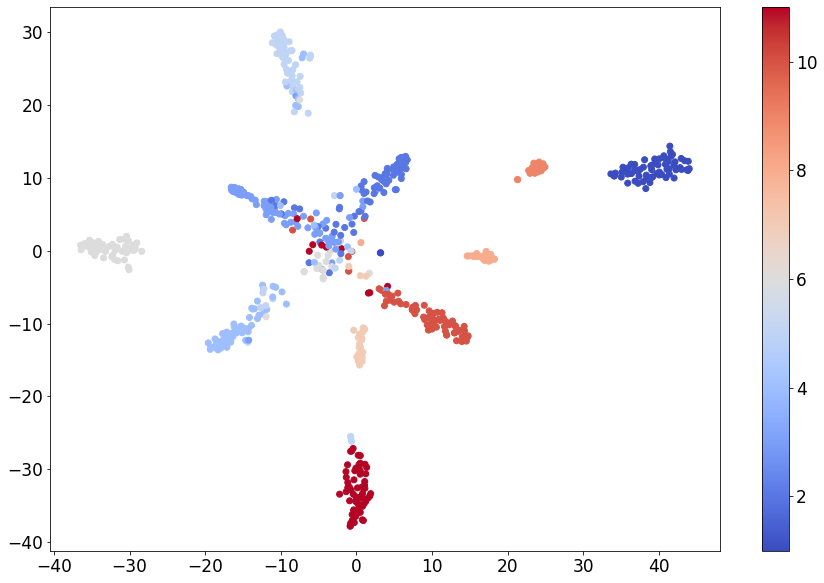

In [99]:
plt.figure(figsize=(15, 10))
plt.scatter(tsne_results[:,0],tsne_results[:,1], c=labels_e, cmap=plt.cm.get_cmap('coolwarm'))
plt.colorbar()